# Outline

The notebook consists of building a Logistic Regression Classifier for CelebA to solve an Binary Image Classification problem whether the image is Male or Female. Training is done on the first 15,000 images, and test is done on the last 5,000 images, and CelebA dataset was modified on the dataset to make this is a very simplified problem, because the aim is intended to demonstrate low-level implementations with JAX of key optimization algorithms from scratch

- Stochastic Gradient Descent
- Stochastic Gradient Descent with Momentum + L2 Regularization
- ADAM
- L-BFGS


# 1. Load Packages

In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax
import jax.numpy as np
import numpy as onp

import pylab as plt
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

import os
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm.notebook import tqdm
from sklearn import metrics
import pandas as pd
import scipy
import time
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')

SEED = 4212
onp.random.seed(SEED)
ia.seed(SEED)

Mounted at /content/drive


# 2. Load data for training and test

In [ ]:
# https://towardsdatascience.com/how-to-successfully-add-large-data-sets-to-google-drive-130beb320f1a

# !unzip drive/MyDrive/data/img_celeba_small.zip > /dev/null

In [ ]:
# source = Path.cwd() / 'drive' / 'MyDrive' / 'data'
# p = source.glob('*')
# files = [x for x in p if x.is_file()]
# files

[PosixPath('/content/drive/MyDrive/data/celeba.csv'),
 PosixPath('/content/drive/MyDrive/data/img_celeba_small.zip')]

In [ ]:
# load attributes csv file
attribute = pd.read_csv(source / "celeba.csv")

path = Path.cwd() / 'img_celeba_small' # path to images
p = path.glob('*.jpg')
all_img = [x for x in p if x.is_file()]

# sort the images by alkphabetical order 
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

# keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


We first check if the labels are correctly labelled before proceeding with train/val/test split.

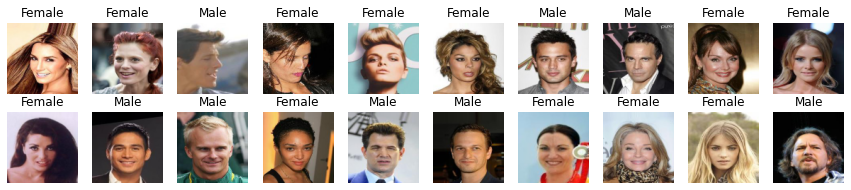

In [ ]:
# check the first 20 images and corresponding labels
plt.figure(figsize=(15,3))

for k in range(20):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(onp.float32)

    #resize to 100x100 for display
    im = resize(im, (100,100) )

    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)

    plt.axis("off")
    
    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")

Out of the 15,000 images in the training data, we further subset into a smaller training and validation dataset to improve training performance. The final train/val/dataset distribution are as follows:

1. Training: 12,000 (60%)
2. Validation: 3,000 (15%)
3. Test: 5,000 (25%)

We check for the distribution of the labels in the datasets we created to see if there exists any class imbalance problems.

In [ ]:
proportion_male = onp.mean(attribute["Male"].values==1)
print(f"Proportion of Males in the dataset: {100*proportion_male:.1f} %",  )

val_index = 12000
train = attribute[:12000]['Male']
val = attribute[12000:15000]['Male']
test = attribute[15000:20000]['Male']

# subset training set by male/female
train_m = train[train==1] # indices of Males in train dataset
train_f = train[train==-1]
print(f"Proportion of Males in Train dataset: {len(train_m)/len(train) * 100:.1f}%")

# subset training set by male/female
val_m = val[val==1] 
val_f = val[val==-1]
print(f"Proportion of Males in Validation dataset: {len(val_m)/len(val) * 100:.1f}%")

# subset training set by male/female
test_m = test[test==1] 
test_f = test[test==-1]
print(f"Proportion of Males in Test dataset: {len(test_m)/len(test) * 100:.1f}%")

Proportion of Males in the dataset: 42.2 %
Proportion of Males in Train dataset: 42.1%
Proportion of Males in Validation dataset: 42.5%
Proportion of Males in Test dataset: 42.0%


We can see that the class distribution is quite balanced, hence we do not need to use any class imbalance treatment and finalize the distribution train/val/test split.

In [ ]:
# compile train, validation, test data
ptrain = train_m.append(train_f)

pval = val_m.append(val_f)

ptest = test_m.append(test_f)

print(f"Training dataset: {ptrain.shape[0]}, Validation dataset: {pval.shape[0]}, Test dataset: {ptest.shape[0]}")

Training dataset: 12000, Validation dataset: 3000, Test dataset: 5000


# 3. Image Pre-Processing

## Resize and change to greyscale

The images were initially loaded in with their original size of 218 by 178 pixels, resized to 122 by 100 pixels with aspect ratio preserved and loaded in grayscale with their pixel intensity rescaled to [0,1].

In [ ]:
h = 122 # image height
w = 100 # image weight

# load and process the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,h,w))

for k in range(len(ptrain)):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(onp.float32)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale

    ptrain_img[k,:,:] = im

 
# load and process the images from the prelim validation set
pval_ind = pval.index.values
pval_img = onp.zeros((len(pval),h,w))

for k in range(len(pval)):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(onp.float32)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    pval_img[k,:,:] = im
    
# load the images from the test set
ntest_img = 5000
ptest_img = onp.zeros((ntest_img,h,w))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(onp.float32)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2) # grayscale
    im = im/255. # rescale
    ptest_img[k,:,:] = im

`ptrain` is a 12000 x 1 array with the indicator values $\{-1, 1\}$ for female and male. `ptrain_img` is a 12000 x 122 x 100 array that contains the relevant images for the preliminary training data.  

`pval` is a 3000 x 1 array with the indicator values $\{-1, 1\}$ for female and male. `pval_img`is a 3000 x 122 x 100 array that contains the relevant images for the preliminary validation data. 

`test` is a 5000 x 1 array with with the indicator values $\{-1, 1\}$ for female and male. `ptest_img`is a 5000 x 122 x 100 array that contains the relevant images for the test data. 

In [ ]:
X_train_init = ptrain_img.reshape(len(ptrain), h*w)
y_train = ptrain.to_numpy(copy=True)

X_val_init = pval_img.reshape(len(pval), h*w)
y_val = pval.to_numpy(copy=True)

X_test_init = ptest_img.reshape(5000, h*w)
y_test = test.to_numpy(copy=True)

print(f"Training: {X_train_init.shape}, {y_train.shape}")
print(f"Validation: {X_val_init.shape}, {y_val.shape}")
print(f"Test: {X_test_init.shape}, {y_test.shape}")

Training: (12000, 12200), (12000,)
Validation: (3000, 12200), (3000,)
Test: (5000, 12200), (5000,)


## Crop and increase contrast



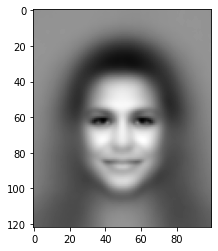

In [ ]:
plt.imshow(onp.mean(ptrain_img, axis=0), cmap='gray')
plt.show()

The average face is located in the middle of the picture and we decided to crop to picture to only retain the face.


Procedures to preprocess images (starting from a 122 by 100 grey scale image):

1. Crop the image to 80 by 60 
2. Increase contrast by:
  - Calculate the minimun and maximun cutoff values using the 15th and 85th quantile of the existing pixle values
  - Normalize pixle values to [0, 1]


In [ ]:
@jax.jit
def crop(x):
  # crop the middle section of a image
  low0, up0 = 30, 110
  low1, up1 = 20, 80
  return x[low0: up0, low1: up1]

@jax.jit
def up_contrast(x):
  # increase contrast by pushing pixels with smaller values to zero and bigger values to 255
  min_val = np.percentile(x, 15)
  max_val = np.percentile(x, 85)
  x = onp.clip(x, min_val, max_val)
  x = ((x - min_val) / (max_val - min_val)) * 255.
  x = x.astype(int)
  return x



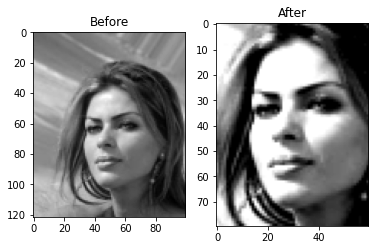

In [ ]:
sample_img = ptrain_img[0]
temp = up_contrast(sample_img)
temp = crop(temp)

f, axes = plt.subplots(1, 2)
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Before')
axes[1].imshow(temp, cmap='gray')
axes[1].set_title('After')

plt.show()

In [ ]:
@jax.jit
def preprocessing(x):
  # crop, increase contrast and normalize pixel values back to [0, 1]
  x = up_contrast(x)
  x = crop(x)
  x = x/onp.max(x)
  return x

vmap_preprocessing = jax.vmap(preprocessing, 0, 0)

X_train = vmap_preprocessing(ptrain_img).reshape(len(ptrain), 80*60)

X_val = vmap_preprocessing(pval_img).reshape(len(pval_img), 80*60)

X_test = vmap_preprocessing(ptest_img).reshape(5000, 80*60)

print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Training: (12000, 4800), (12000,)
Validation: (3000, 4800), (3000,)
Test: (5000, 4800), (5000,)


# 4. Training 

These are the models we will be optimising:

* Logistic regression loss function with L2 penalty:
$$ \frac{1}{N} \, \sum_{i=1}^N \log(1 + \exp(-y_i \, \langle \beta, x_i \rangle)) + \frac{\lambda}{N} \| \beta \|^2$$

* Logistic probability:
$$P(y=1 | x) = \frac{1}{1 + \exp(- \langle \beta, x \rangle)}$$



In [ ]:
@jax.jit
def prediction_single(beta, x):
    """ beta is a vector of dimension 10000, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

# vectorize the single prediction on whole dataset
prediction_data = jax.jit(jax.vmap(prediction_single, in_axes=(None,0)))

@jax.jit
def loss_single(beta,x,y):
    """
    beta: vector of dimension 100*100
    x: vector of dimension 100*100
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

# vectorize the single loss on whole dataset
loss_dataset = jax.jit(jax.vmap(loss_single, in_axes=(None,0,0)))

@jax.jit
def loss(beta, data, y, reg=0): # Loss function, default is no regularization
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) + reg*np.mean((beta)**2)

grad_loss = jax.jit(jax.grad(loss))

@jax.jit
def accuracy(beta, data, y, threshold):
    pred = prediction_data(beta, data)
    prediction_binary = (pred > threshold).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    return np.mean(prediction_sign == y)

For each optimisation method, we plot the loss history, the accuracy history as well as the ROC curve and report the AUC.

In [ ]:
# function to plot ROC curve
def plot_ROC(model, method, data, y):
    y_pred_proba = prediction_data(model,data)
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(fpr,tpr,label=method+", AUC="+"{0:.3f}".format(auc))
    plt.legend(loc=4)
    plt.show()

Initialise $\beta \sim N(0, \frac{1}{\sqrt{D}})$ where $D=80*60$

In [ ]:
# Initialise beta
D = 80*60
beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

## 4.1 Baseline Classifier

Our model should beat a baseline classifier that classifies every person as female, with an expected accuracy rate of 57.47%.

Accuracy: 57.47%


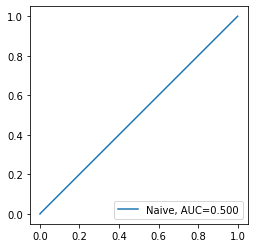

In [ ]:
c = onp.repeat(-1, len(pval))
print(f"Accuracy: {sum(c==y_val)/len(pval)*100:.2f}%")
    
plot_ROC(onp.repeat(-1, D), "Naive", X_val, y_val)

## 4.2 Stochastic Gradient Descent
Because naive Gradient Descent involves calculating $\nabla F(x)$ which can get computationally expensive as $n$ increases, Stochastic Gradient Descent, and its variants are ways designed to speed up training. 

In [ ]:
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Training: (12000, 4800), (12000,)
Validation: (3000, 4800), (3000,)
Test: (5000, 4800), (5000,)


In [ ]:
n_epoch = 100
batch_size = 100  #size of the mini-batch
beta = onp.copy(beta_init)
mov_avg_param = 0

learning_rate = 0.001
loss_train_hist = []
loss_val_hist = []

#initialize the gradient
gradient = grad_loss(beta, X_train, y_train)
best_beta_sgd = onp.zeros(D)

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch
        #select at random "batch_size" random data point
        index_ = onp.random.choice(ntrain_img, batch_size, replace=False)
        
        gradient_local = grad_loss(beta, X_train[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    loss_train = loss(beta, X_train, y_train)
    loss_val = loss(beta, X_val, y_val)
    
    if len(loss_val_hist)>0:
        if loss_val <= loss_val_hist[-1]:
            best_beta_sgd = beta
        
    loss_train_hist.append(loss_train)
    loss_val_hist.append(loss_val)
    
    timing = time.time() - start
    print(f"epoch:{epoch:.0f} \t time:{timing:.3f} \t Loss (Train):{loss_train:.3f} \t Loss (Val):{loss_val:.3f}")

epoch:0 	 time:1.252 	 Loss (Train):0.624 	 Loss (Val):0.628
epoch:1 	 time:2.022 	 Loss (Train):0.591 	 Loss (Val):0.599
epoch:2 	 time:2.780 	 Loss (Train):0.565 	 Loss (Val):0.576
epoch:3 	 time:3.502 	 Loss (Train):0.548 	 Loss (Val):0.561
epoch:4 	 time:4.241 	 Loss (Train):0.529 	 Loss (Val):0.543
epoch:5 	 time:4.987 	 Loss (Train):0.514 	 Loss (Val):0.531
epoch:6 	 time:5.732 	 Loss (Train):0.504 	 Loss (Val):0.522
epoch:7 	 time:6.492 	 Loss (Train):0.491 	 Loss (Val):0.510
epoch:8 	 time:7.250 	 Loss (Train):0.483 	 Loss (Val):0.501
epoch:9 	 time:8.029 	 Loss (Train):0.473 	 Loss (Val):0.492
epoch:10 	 time:8.783 	 Loss (Train):0.468 	 Loss (Val):0.488
epoch:11 	 time:9.538 	 Loss (Train):0.464 	 Loss (Val):0.484
epoch:12 	 time:10.287 	 Loss (Train):0.461 	 Loss (Val):0.481
epoch:13 	 time:11.038 	 Loss (Train):0.457 	 Loss (Val):0.477
epoch:14 	 time:11.787 	 Loss (Train):0.453 	 Loss (Val):0.474
epoch:15 	 time:12.563 	 Loss (Train):0.451 	 Loss (Val):0.472
epoch:16 	 tim

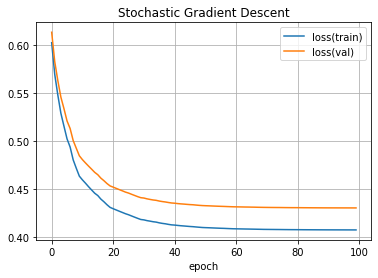

In [ ]:
plt.plot(loss_train_hist, label="loss(train)")
plt.plot(loss_val_hist, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")
plt.show()

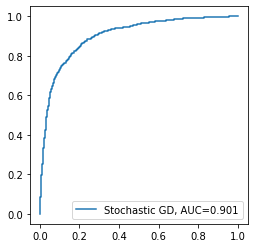

In [ ]:
plot_ROC(best_beta_sgd, "Stochastic GD", X_val, y_val)

Our Validation AUC for Stochastic Gradient Descent is 0.901, and this serves as a baseline for our other algorithms.

## 4.3 SGD with momentum and L2 regularization

In this section, we explore the performance using SGD again. However, this time with momentum and L2 regularization.

In [ ]:
def train_sgd2(X_train, X_val, y_train, y_val, beta_init, minibatch_size, n_epoch, eta, gamma, momentum_para, print_flag=False, random_state=1):
    onp.random.seed(random_state)

    minibatch_index = -1
    loss_epoch_history = [] 
    val_loss_epoch_history = []
    
    train_acc_hist = []
    val_acc_hist = []
    
    beta = beta_init
    beta_old = beta_init
    N_train = X_train.shape[0]

    for epoch in range(n_epoch):
        n_minibatch = N_train // minibatch_size  # number of minibatches in one epoch

        loss_batch_history = []
        for _ in range(n_minibatch):
            # computes the indices of images to process
            minibatch_index += 1
            indices = onp.arange(minibatch_index*minibatch_size,
                                (minibatch_index+1)*minibatch_size)
            indices = indices.astype(int) % N_train # takes everything modulo N_train

            # creates the minibatch of images/labels 
            X_batch = X_train[indices,:]
            Y_batch = y_train[indices]

            # computes stochastic gradient estimate
            g = grad_loss(beta, X_batch, Y_batch, gamma)
            
            #gradient update
            beta, beta_old = beta - eta * g + momentum_para*(beta - beta_old), beta

        # compute the average loss over the epoch
        loss_on_epoch = loss(beta, X_train, y_train, gamma)
        loss_epoch_history.append(loss_on_epoch)
        
        val_loss_on_epoch = loss(beta, X_val, y_val, gamma)
        val_loss_epoch_history.append(val_loss_on_epoch)
        
        train_acc = accuracy(beta, X_train, y_train, 0.5)
        train_acc_hist.append(train_acc)
        val_acc = accuracy(beta, X_val, y_val, 0.5)
        val_acc_hist.append(val_acc)
        
        if print_flag:
            print(f"epoch:{epoch+1} \t train_loss: {loss_on_epoch: 3.3f} \t val_loss: {val_loss_on_epoch: 3.3f} \t train_acc: {train_acc: 3.3f} \t val_acc: {val_acc: 3.3f}")
    return beta, loss_epoch_history, val_loss_epoch_history, train_acc_hist, val_acc_hist

In the interest of time, a greedy grid search for the hyperparameters is done to arrive at the best model.

In [ ]:
kwargs = {'n_epoch': 28,
          'minibatch_size': 50,
          'eta': 0.01,
          'gamma': 0.01,
          'momentum_para': 0.7,
          'beta_init': onp.copy(beta_init)}

beta_sgd_reg_m, loss_epoch_history, val_loss_epoch_history, train_acc_hist, val_acc_hist = train_sgd2(X_train, X_val, y_train, y_val,  
                                                                                           print_flag=True, **kwargs)

epoch:1 	 train_loss:  0.344 	 val_loss:  0.376 	 train_acc:  0.854 	 val_acc:  0.836
epoch:2 	 train_loss:  0.390 	 val_loss:  0.432 	 train_acc:  0.816 	 val_acc:  0.799
epoch:3 	 train_loss:  0.320 	 val_loss:  0.360 	 train_acc:  0.861 	 val_acc:  0.843
epoch:4 	 train_loss:  0.272 	 val_loss:  0.309 	 train_acc:  0.891 	 val_acc:  0.874
epoch:5 	 train_loss:  0.249 	 val_loss:  0.285 	 train_acc:  0.902 	 val_acc:  0.886
epoch:6 	 train_loss:  0.240 	 val_loss:  0.276 	 train_acc:  0.905 	 val_acc:  0.891
epoch:7 	 train_loss:  0.237 	 val_loss:  0.273 	 train_acc:  0.906 	 val_acc:  0.891
epoch:8 	 train_loss:  0.237 	 val_loss:  0.273 	 train_acc:  0.907 	 val_acc:  0.894
epoch:9 	 train_loss:  0.236 	 val_loss:  0.274 	 train_acc:  0.907 	 val_acc:  0.891
epoch:10 	 train_loss:  0.235 	 val_loss:  0.274 	 train_acc:  0.908 	 val_acc:  0.893
epoch:11 	 train_loss:  0.234 	 val_loss:  0.274 	 train_acc:  0.909 	 val_acc:  0.893
epoch:12 	 train_loss:  0.232 	 val_loss:  0.274 	 t

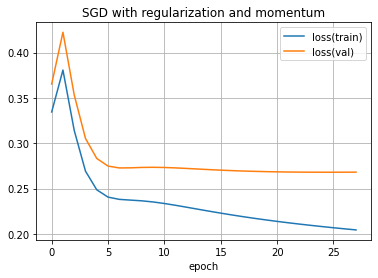

In [ ]:
plt.plot(loss_epoch_history, label="loss(train)")
plt.plot(val_loss_epoch_history, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("SGD with regularization and momentum")
plt.show()

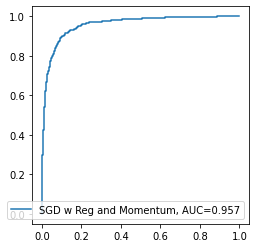

In [ ]:
plot_ROC(beta_sgd_reg_m, "SGD w Reg and Momentum", X_val, y_val)

It seems that adding regularization and momentum indeed improves the performance of SGD. This can be due to the better generalization property due to regularization. Next, we try another popular optimisation method, Adam.

## 4.4 Adam

ADAM is a popular algorithm in deep learning, and is often suggested as the default optimisation method for deep learning models by libraries such as tensorflow and pytorch. This was the reason we decided to use this algorithm for ourselves, and see what kind of results it could achieve. The parameters of beta1 and beta2 were chosen using grid search, and it was found that the higher beta1 and beta2 were, the better ADAM's performance was.


In [ ]:
def ADAM(Xt, Yt, Xv, Yv, beta1=0.9, beta2=0.999, n_iter=500, eta=1e-3, eps=1e-8):
    
    # from https://arxiv.org/pdf/1412.6980.pdf
    # notation apart from step size follows similarly.
    # eps is like a smoothing param: ensures we don't divide by 0
    # b1/2 are just hyperparams to tune, between 0, 1
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    m = onp.zeros(Xt.shape[1])
    v = onp.zeros(Xt.shape[1])
    beta_init = onp.zeros(Xt.shape[1])
    beta = onp.copy(beta_init)
    train_loss_history.append(loss(beta, Xt, Yt))
    train_acc_history.append(accuracy(beta, Xt, Yt, 0.5))
    val_loss_history.append(loss(beta, Xv, Yv))
    val_acc_history.append(accuracy(beta, Xv, Yv, 0.5))
    for k in tqdm(range(n_iter)):
        # update hyperparams
        b1 = beta1**(1+k)
        b2 = beta2**(1+k)
        
        # update in function params
        gradient = grad_loss(beta, Xt, Yt)
        
        # update biased moment estimates
        m = b1*m + (1-b1)*gradient
        v = b2*v + (1-b2)*gradient**2
        
        # compute bias corrected moment estimates
        mhat = m/(1-b1)
        vhat = v/(1-b2)
        
        # compute next estimate of beta
        beta = beta - eta * mhat/(np.sqrt(vhat) + eps)
        
        # save
        train_loss_history.append(loss(beta, Xt, Yt))
        train_acc_history.append(accuracy(beta, Xt, Yt, 0.5))
        val_loss_history.append(loss(beta, Xv, Yv))
        val_acc_history.append(accuracy(beta, Xv, Yv, 0.5))
    
    return beta, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
beta_adam, train_loss_history, train_acc_history, val_loss_history, val_acc_history = \
ADAM(X_train, y_train, X_val, y_val, beta1=0.9999, beta2=0.9999, n_iter=300, eta=1e-3)

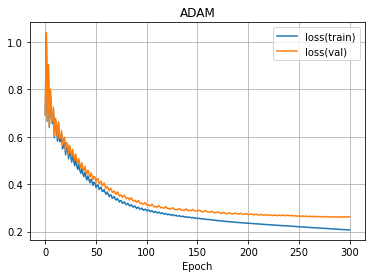

In [ ]:
plt.plot(train_loss_history, label="loss(train)")
plt.plot(val_loss_history, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM")
plt.show()

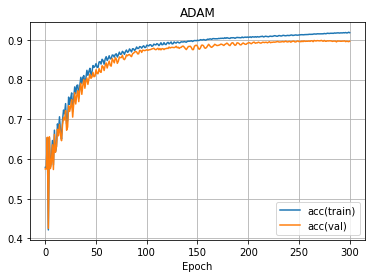

In [ ]:
plt.plot(train_acc_history, label="acc(train)")
plt.plot(val_acc_history, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM")
plt.show()

In [ ]:
print(val_acc_history[-1])
print(train_acc_history[-1])

0.8963333333333333
0.9179166666666666


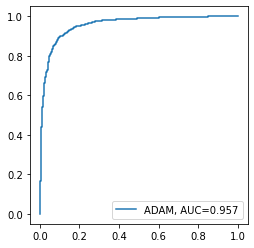

In [ ]:
plot_ROC(beta_adam, "ADAM", X_val, y_val)

Now we also try, as proof, that using the preprocessed data does not 
negatively affect performance, and in fact speeds up training while improving accuracy and convergence of ADAM.

In [ ]:
beta_adam_non_preprocessed, train_loss_history, train_acc_history, val_loss_history, val_acc_history = \
ADAM(X_train_init, y_train, X_val_init, y_val, beta1=0.9999, beta2=0.9999, n_iter=300, eta=1e-3)

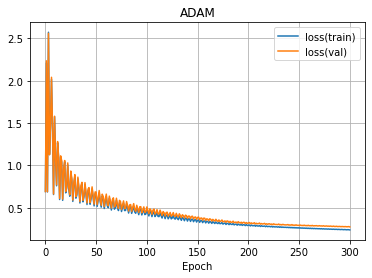

In [ ]:
plt.plot(train_loss_history, label="loss(train)")
plt.plot(val_loss_history, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM")
plt.show()

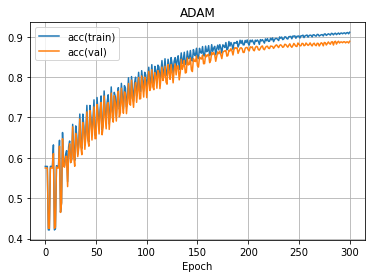

In [ ]:
plt.plot(train_acc_history, label="acc(train)")
plt.plot(val_acc_history, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM")
plt.show()

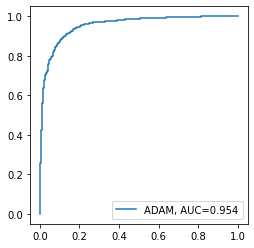

In [ ]:
plot_ROC(beta_adam, "ADAM", X_val_init, y_val)

Thus, our even though our the validation ROC is similar to using ADAM on the preprocessed data, it trains much faster and ADAM also converges much more smoothly to the minimum using our preprocessed data. 

We can see that ADAM achieves good results, with an AUC of 0.957 on our preprocessed data. Let us now explore what happens if we use regularisation. We first try regularisation with a parameter of 0.01, then 5.

In [ ]:
def ADAM_L2(Xt, Yt, Xv, Yv, gamma=0.01, beta1=0.9, beta2=0.999, n_iter=500, eta=1e-3, eps=1e-8):
    
    # from https://arxiv.org/pdf/1412.6980.pdf
    # notation apart from step size follows similarly.
    # eps is like a smoothing param: ensures we don't divide by 0
    # b1/2 are just hyperparams to tune, between 0, 1
    
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    m = onp.zeros(Xt.shape[1])
    v = onp.zeros(Xt.shape[1])
    beta_init = onp.zeros(Xt.shape[1])
    beta = onp.copy(beta_init)
    train_loss_history.append(loss(beta, Xt, Yt, gamma))
    train_acc_history.append(accuracy(beta, Xt, Yt, 0.5))
    val_loss_history.append(loss(beta, Xv, Yv, gamma))
    val_acc_history.append(accuracy(beta, Xv, Yv, 0.5))
    for k in tqdm(range(n_iter)):
        # update hyperparams
        b1 = beta1**(1+k)
        b2 = beta2**(1+k)
        
        # update in function params
        gradient = grad_loss(beta, Xt, Yt, gamma)
        
        # update biased moment estimates
        m = b1*m + (1-b1)*gradient
        v = b2*v + (1-b2)*gradient**2
        
        # compute bias corrected moment estimates
        mhat = m/(1-b1)
        vhat = v/(1-b2)
        
        # compute next estimate of beta
        beta = beta - eta * mhat/(np.sqrt(vhat) + eps)
        
        # save
        train_loss_history.append(loss(beta, Xt, Yt,gamma))
        train_acc_history.append(accuracy(beta, Xt, Yt, 0.5))
        val_loss_history.append(loss(beta, Xv, Yv, gamma))
        val_acc_history.append(accuracy(beta, Xv, Yv, 0.5))
    
    return beta, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [ ]:
beta_adam_l2, train_loss_history_l2, train_acc_history_l2, val_loss_history_l2, val_acc_history_l2 = \
ADAM_L2(X_train, y_train, X_val, y_val, beta1=0.9999, beta2=0.9999, n_iter=300, eta=1e-3)

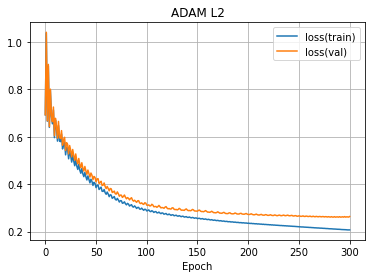

In [ ]:
plt.plot(train_loss_history_l2, label="loss(train)")
plt.plot(val_loss_history_l2, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM L2")
plt.show()

In [ ]:
print(val_acc_history_l2[-1])
print(train_acc_history_l2[-1])

0.8963333333333333
0.9180833333333333


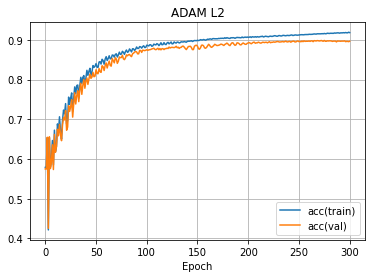

In [ ]:
plt.plot(train_acc_history_l2, label="acc(train)")
plt.plot(val_acc_history_l2, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM L2")
plt.show()

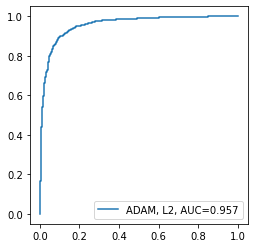

In [ ]:
plot_ROC(beta_adam_l2, "ADAM, L2", X_val, y_val)

In [ ]:
beta_adam_l2, train_loss_history_l2, train_acc_history_l2, val_loss_history_l2, val_acc_history_l2 = \
ADAM_L2(X_train, y_train, X_val, y_val, gamma=5, beta1=0.9999, beta2=0.9999, n_iter=300, eta=1e-3)

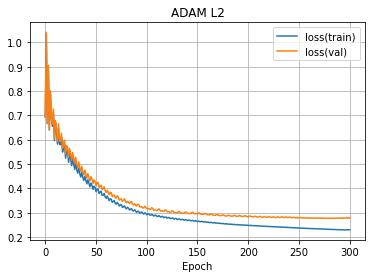

In [ ]:
plt.plot(train_loss_history_l2, label="loss(train)")
plt.plot(val_loss_history_l2, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM L2")
plt.show()

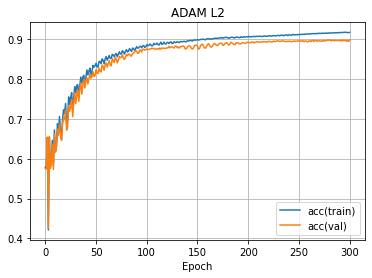

In [ ]:
plt.plot(train_acc_history_l2, label="acc(train)")
plt.plot(val_acc_history_l2, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("ADAM L2")
plt.show()

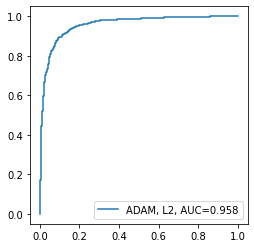

In [ ]:
plot_ROC(beta_adam_l2, "ADAM, L2", X_val, y_val)

Thus we can see that a higher regularisation parameter gives a slightly better result, but this improvement is not very noticeable: the non-penalised model still performs the about the same on the data. All the results above show that ADAM is able to perform well. However, its drawback is that it takes more iterations than other methods for the loss to stabilise and monotonically decrease. This means that ADAM will take longer to achieve good results. Now we move on to second order methods.



## 4.5 L-BFGS

Limited-BFGS is an optimization algorithm that uses 2nd order methods, and is popular for parameter estimation. It is a method that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory. From our understanding, second order methods could potentially converge on a global minimum faster than first order methods. Thus, we use L-BFGS to see if it can out-perform our above methods in both runtime and accuracy.

In [ ]:
def loss_single(beta,x,y):
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

# Ridge
def lossl2(beta, data, y, reg): 
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) + reg*np.mean((beta)**2)

grad_lossl2 = jax.jit(jax.grad(lossl2))

def loss_wrapper(beta):
    return lossl2(beta, X_train, y_train, 1)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    return onp.array(grad_loss_wrapper(beta))

loss_train_bfgs = []; loss_val_bfgs = []
# store computed time
time_hist = []  

# saving the best model
best_beta = onp.zeros(D) 
beta = onp.copy(beta_init)

def save_traj(beta):
    global best_beta
    loss_train = lossl2(beta, X_train, y_train, 1)
    loss_val = lossl2(beta, X_val, y_val, 1)
    timing = time.time() - start
    
    print(f"Time:{timing:.3f} \t Loss(train):{loss_train:.3f} \t Loss(val):{loss_val:.3f}")
    
    time_hist.append(timing)
    loss_train_bfgs.append(loss_train)
    loss_val_bfgs.append(loss_val)
    
    # saving model with the lowest validation loss
    if loss_val <= loss_val_bfgs[-1]: 
        best_beta = beta
        
#run LBFGS
start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper, # function to minimize
                                x0 = onp.array(beta_init), # initial guess
                                method='L-BFGS-B',  
                                jac=gradient_wrapper, # computing gradient
                                callback=save_traj, # save results for future use
                                options={"maxiter":100}) 

Time:7.325 	 Loss(train):0.692 	 Loss(val):0.691
Time:7.473 	 Loss(train):0.689 	 Loss(val):0.688
Time:7.656 	 Loss(train):0.663 	 Loss(val):0.664
Time:7.861 	 Loss(train):0.636 	 Loss(val):0.640
Time:8.021 	 Loss(train):0.600 	 Loss(val):0.609
Time:8.202 	 Loss(train):0.565 	 Loss(val):0.581
Time:8.378 	 Loss(train):0.543 	 Loss(val):0.565
Time:8.553 	 Loss(train):0.525 	 Loss(val):0.551
Time:8.738 	 Loss(train):0.504 	 Loss(val):0.534
Time:8.917 	 Loss(train):0.461 	 Loss(val):0.493
Time:9.100 	 Loss(train):0.419 	 Loss(val):0.451
Time:9.278 	 Loss(train):0.400 	 Loss(val):0.429
Time:9.459 	 Loss(train):0.380 	 Loss(val):0.410
Time:9.768 	 Loss(train):0.369 	 Loss(val):0.395
Time:9.949 	 Loss(train):0.360 	 Loss(val):0.388
Time:10.130 	 Loss(train):0.355 	 Loss(val):0.384
Time:10.309 	 Loss(train):0.341 	 Loss(val):0.371
Time:10.496 	 Loss(train):0.318 	 Loss(val):0.346
Time:10.695 	 Loss(train):0.306 	 Loss(val):0.331
Time:10.872 	 Loss(train):0.298 	 Loss(val):0.323
Time:11.037 	 L

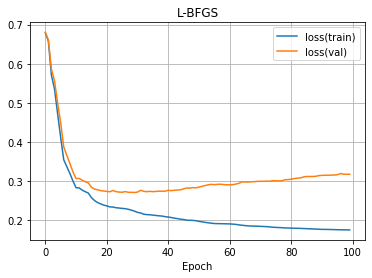

In [ ]:
plt.plot(loss_train_bfgs, label="loss(train)")
plt.plot(loss_val_bfgs, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("L-BFGS")
plt.show()

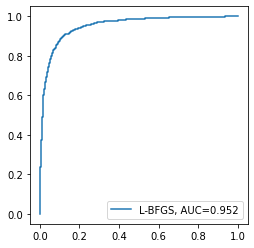

In [ ]:
plot_ROC(best_beta, "L-BFGS", X_val, y_val)

To get accuracy at the different thresholds:


In [ ]:
for i in list(range(1,11)):
    acc = accuracy(best_beta, X_val, y_val, i/10)
    print("Threshold: {0:.1f} \t Accuracy: {1:.3f}".format(i/10, acc))

Threshold: 0.1 	 Accuracy: 0.840
Threshold: 0.2 	 Accuracy: 0.868
Threshold: 0.3 	 Accuracy: 0.882
Threshold: 0.4 	 Accuracy: 0.891
Threshold: 0.5 	 Accuracy: 0.891
Threshold: 0.6 	 Accuracy: 0.888
Threshold: 0.7 	 Accuracy: 0.881
Threshold: 0.8 	 Accuracy: 0.868
Threshold: 0.9 	 Accuracy: 0.834
Threshold: 1.0 	 Accuracy: 0.575


L-BFGS proved to have a AUC of 0.952 which is higher than SGD and has an accuracy of 0.891 at a threshold of 0.5. Moreover, L-BFGS took a considerably shorter time to run than all our first order methods, taking almost half the time as compared to SGD. This shows the fruits of our exploration of second order methods.

# 5. Validation of algorithms

In this section, we compare the validation performance across algorithms to finalize the choice of algorithm we will use to fit on the final model.

Metrics to evaluate:
1. Compare using validation AUC
2. Compare using time taken to train 

We note that the validation AUC is comparable for all 3 methods we tried (SGD with Momentum and L2 Regularization, L-BFGS, Adam), we fix the number of epochs and observe the runtime to fit the training data to decide the most efficient method. 


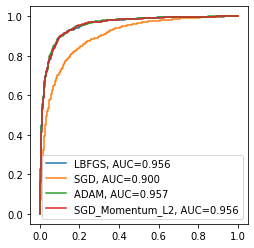

In [ ]:
models = [best_beta, best_beta_sgd, beta_adam, beta_sgd_reg_m]
methods = ["LBFGS", "SGD", "ADAM", "SGD_Momentum_L2"]
for m, method in zip(models, methods):
    y_pred_proba = prediction_data(m, X_val)
    fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
    auc = metrics.roc_auc_score(y_val, y_pred_proba)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot(fpr,tpr,label=method+", AUC="+"{0:.3f}".format(auc))
plt.legend(loc=4)
plt.show()

Here we see that the AUC of SGD with momentum, ADAM and L-BFGS are clear winners. However, each model's AUC is too close to one another, and this metric does not yield a clear best model, only a 3 way tie. We further compare these best models based on their runtime, using a fixed number of epochs.

In [ ]:
n_epoch = 100

In [ ]:
%%time
_ = scipy.optimize.minimize(fun = loss_wrapper, # function to minimize
                                x0 = onp.array(beta_init), # initial guess
                                method='L-BFGS-B',  
                                jac=gradient_wrapper, # computing gradient
                                # callback=save_traj, # save results for future use
                                options={"maxiter":n_epoch}) 

CPU times: user 15.2 s, sys: 42.3 ms, total: 15.3 s
Wall time: 14 s


In [ ]:
%%time
_, _, _, _, _ = ADAM(X_train, y_train, X_val, y_val, beta1=0.9999, beta2=0.9999, n_iter=n_epoch, eta=1e-3)


CPU times: user 20.2 s, sys: 164 ms, total: 20.4 s
Wall time: 19.1 s


In [ ]:
%%time
kwargs = {'n_epoch': 100,
          'minibatch_size': 50,
          'eta': 0.01,
          'gamma': 0.01,
          'momentum_para': 0.7,
          'beta_init': onp.copy(beta_init)}
train_sgd2(X_train, X_val, y_train, y_val, print_flag=False, **kwargs)

CPU times: user 2min 45s, sys: 26.2 s, total: 3min 11s
Wall time: 2min 24s


It makes sense that the second order methods are faster than first order methods, and thus we see that L-BFGS is 5 seconds faster than our fastest first order method, Adam. From this section we can conclude that L-BFGS is our best model. Next we will attempt to use Data Augmentation with our L-BFGS model to see if we can improve its performance.

# 6. Data augmentation

This section explores if data augmentation can improve performance of our models through techniques as discussed below:

1. Horizontal flip 50% of all images
2. Crops by 0-20% of their H/W
3. Affine Rotations  \
    3.1 Scale to 80-120% of image H/W (per axis)
    3.2 Translate by -20 to +20 relative to H/W (per axis)
    3.3 Rotate by -25 to 25 degrees
    3.4 Shear by -8 to 8 degrees
4. Gaussian Blur with a sigma of 0 to 0.5
5. Linear Contrast improve or worsen contrast per image
6. Gaussian Noise randomly sampled per channel and pixel

The augmentation techniques are applied in random order, and each technique is only be applied sometimes (50%)

In [ ]:
PROB = 0.5
seq = iaa.Sequential([
    iaa.Sometimes(
        PROB,
        iaa.Fliplr(0.5)
    ), # random horizontal flips
    iaa.Sometimes(
        PROB,
        iaa.Crop(percent=(0, 0.2))
    ), # random crops
    iaa.Sometimes(
        PROB,
        iaa.GaussianBlur(sigma=(0, 0.5)) 
    ), # Small gaussian blur with random sigma between 0 and 0.5.
    iaa.Sometimes(
        PROB,
        iaa.LinearContrast((0.75, 1.5))
    ),  # Strengthen or weaken the contrast in each image.
    iaa.Sometimes(
        PROB,
        iaa.AdditiveGaussianNoise(scale=(0, 0.1)),
    ), 
    # dtype 'float64' in augmenter 'UnnamedCoarseDropout' (class 'MultiplyElementwise'), which is a 
    # forbidden dtype (uint32, uint64, uint128, uint256, int32, int64, int128, int256, float64, float96, float128, float256)
    iaa.Sometimes(
        PROB,
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25), 
        shear=(-8,8)
        ),    ), 
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.

], random_order=True)



In [ ]:
h = 122 # image height
w = 100 # image weight

# load and process the images from the prelim training set
ptrain_aug = onp.zeros((ntrain_img,h,w))

for k in range(len(ptrain)):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(onp.float32)
    im = resize(im, (h,w))
    aug = seq(image=im) # augmentation takes a long time, comment this out and load the data augmentation directly
    aug = onp.mean(aug, axis=2) # grayscale
    aug = aug/255. # rescale

    ptrain_aug[k,:,:] = aug

Example

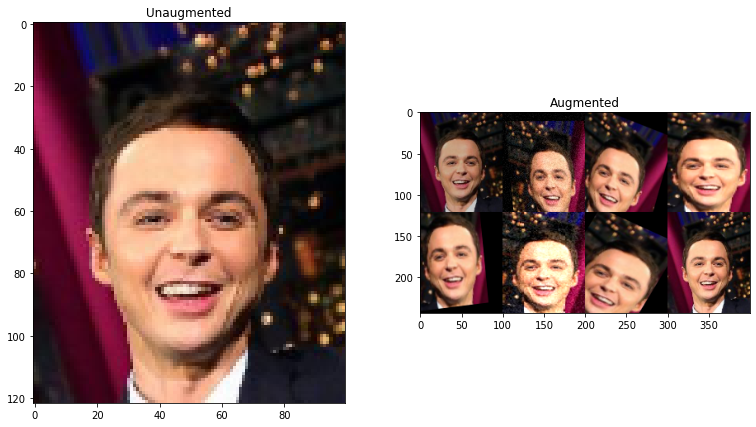

In [ ]:
images = im/255.
images_aug = [seq(image=images) for _ in range(8)] # list of augmented images

f, axes = plt.subplots(1, 2, figsize=(13, 7))
axes[0].set_title('Unaugmented')
axes[0].imshow(images)

axes[1].set_title('Augmented')
axes[1].imshow(ia.draw_grid(images_aug, cols=4, rows=2)) 
plt.show()

We observe that sometimes there is very little data augmentation done, whereas at other times the augmented image is very different from the original image.

In [ ]:
X_train_aug = ptrain_aug.reshape(len(ptrain_aug), h*w)
y_train = ptrain.to_numpy(copy=True)
print(f"Training aug: {X_train_aug.shape}, {y_train.shape}")

Training aug: (12000, 12200), (12000,)



The augmented dataset created is separate from our train dataset to compare if image augmentation can improve the performance of our classifier in our next experiments. We now preprocess the images to create our training, test and validation arrays.


In [ ]:
def loss_wrapper_new(beta):
    return lossl2(beta, X_train_aug, y_train, 1)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper_new))    

def gradient_wrapper(beta):
    return onp.array(grad_loss_wrapper(beta))

loss_train_bfgs = []; loss_val_bfgs = []
time_hist = []  

def save_traj_new(beta):
    global best_beta_new
    loss_train = lossl2(beta, X_train_aug, y_train, 1)
    loss_val = lossl2(beta, X_val_old, y_val, 1)

    timing = time.time() - start
    
    print(f"Time:{timing:.3f} \t Loss(train):{loss_train:.3f} \t Loss(val):{loss_val:.3f}")
    
    time_hist.append(timing)
    loss_train_bfgs.append(loss_train)
    loss_val_bfgs.append(loss_val)

    
    # saving model with the lowest validation loss
    if loss_val <= loss_val_bfgs[-1]: 
        best_beta_new = beta
        
beta_init_new = onp.random.normal(0, 1, h*w)

We then train on the augmented dataset with the best performing method (L-BFGS), and report its validation AUC

In [ ]:

# saving the best model
best_beta_new = onp.zeros(h*w) 

start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper_new, # function to minimize
                                x0 = beta_init_new, # initial guess
                                method='L-BFGS-B',  
                                jac=gradient_wrapper, # computing gradient
                                callback=save_traj_new, # save results for future use
                                options={"maxiter":100}) 

Time:7.757 	 Loss(train):11.576 	 Loss(val):10.945
Time:8.104 	 Loss(train):11.401 	 Loss(val):10.869
Time:8.562 	 Loss(train):9.809 	 Loss(val):9.865
Time:9.015 	 Loss(train):8.744 	 Loss(val):8.591
Time:9.482 	 Loss(train):7.853 	 Loss(val):7.158
Time:9.911 	 Loss(train):7.612 	 Loss(val):6.921
Time:10.371 	 Loss(train):7.343 	 Loss(val):6.703
Time:10.839 	 Loss(train):6.938 	 Loss(val):6.258
Time:11.289 	 Loss(train):6.349 	 Loss(val):5.441
Time:11.754 	 Loss(train):6.162 	 Loss(val):5.213
Time:12.220 	 Loss(train):5.965 	 Loss(val):5.017
Time:12.682 	 Loss(train):5.785 	 Loss(val):4.832
Time:13.152 	 Loss(train):5.429 	 Loss(val):4.552
Time:13.925 	 Loss(train):5.335 	 Loss(val):4.484
Time:14.372 	 Loss(train):5.135 	 Loss(val):4.383
Time:14.834 	 Loss(train):5.083 	 Loss(val):4.359
Time:15.286 	 Loss(train):4.996 	 Loss(val):4.311
Time:15.747 	 Loss(train):4.952 	 Loss(val):4.274
Time:16.208 	 Loss(train):4.908 	 Loss(val):4.224
Time:16.689 	 Loss(train):4.852 	 Loss(val):4.151
Ti

## Results

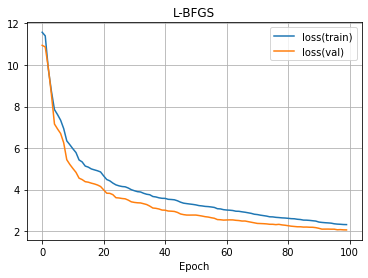

In [ ]:
plt.plot(loss_train_bfgs, label="loss(train)")
plt.plot(loss_val_bfgs, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("Epoch")
plt.title("L-BFGS")
plt.show()

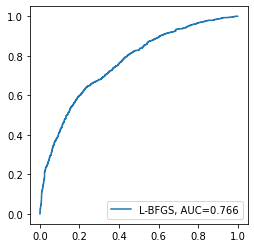

In [ ]:
plot_ROC(best_beta_new, "L-BFGS", X_val_old, y_val)

## Comments

Augmentation does not seem to generate better performance directly. We hypothesize that combining the augmented dataset with the unaugmented dataset to have a training dataset can potentially improve our model to generalize better.  However, when we ran into hardware limitations when combining the datasets together. The training dataset is now twice in size, crashing our Colab environment because it was using well above 12GB RAM limit.

We experimented with downsizing our training dataset further, but this causes too much information loss in the data. A possible extension to this work we can explore if we can combine the augmented dataset with the unaugmented dataset together for training.

# 7. Conclusion

Combining the method that returned the highest accuracy (L-BFGS), we fit our best performing model, then evaluate on the test set.

In [ ]:
print("Train Set Results")
accuracy(best_beta, X_train, y_train, 0.5)

Train Set Results


Buffer(0.92808333, dtype=float64)

In [ ]:
print("Validation Set Results")
accuracy(best_beta, X_val, y_val, 0.5)

Validation Set Results


Buffer(0.89566667, dtype=float64)

In [ ]:
print("Test Set Results")
accuracy(best_beta, X_test, y_test, 0.5)

Test Set Results


DeviceArray(0.9046, dtype=float64)

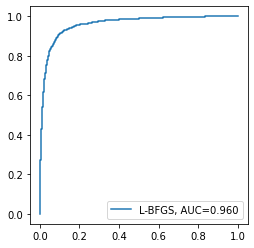

In [ ]:
plot_ROC(best_beta, "L-BFGS", X_test, y_test)

In conclusion, our final model for classifying an image of a person as male or female is to first convert the image to grayscale, then crop it and increase contrast, before using L-BFGS to train our model. Our final model achieves an accuracy of 90% on the test set.